# PROJET 7

### Import des librairies

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, roc_auc_score, f1_score, 
                             recall_score, make_scorer, confusion_matrix)
import pickle
###

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')


/Users/marie/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Lecture des fichiers

In [2]:
path = os.getcwd()
listdir(path + "/" +"data")

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

### Récupération du travail des features du pré-traitement suivant :
https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

Le travail des features à été repris à parti des données présentes dans le notebook au dessus

### Step 1 : Prétraitement des données des applications précédentes 

#### Les données des applications précédentes sont traités de la manière suivante:

    1. Import des données contenues dans previous application
    2. Encodage des données catégorielles
    3. Suppression des valeurs supérieurs à une année dans les cases contenant des nombres de jours 
    4. Création d'une feature supplémentaire correpondant au pourcentage crédit accordé par rapport au montant demandé
    5. Création pour les valeurs numériques de features supplémentaire tels que :
            - Le minimum
            - Le maximum
            - La moyenne
            - La variance
            - La somme
    6. Récupération de la moyenne pour les valeurs catégorielles
    
#### Les données des étapes 5 et 6 sont créés pour différents types d'application: 
     1. Toutes les applications précédentes
     2. Uniquement les applications précédentes approuvées
     3. Uniquement les application précédentes refusées

In [3]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    return prev_agg

### Step 2 : Prétraitement des données de bureau et bureau  balance 

#### Les données des bureau et des balances par bureau sont traités de la manière suivante:

    1. Import des données contenues dans bureau et bureau balance
    2. Encodage des données catégorielles pour les deux dataframes 
    3. Création pour les valeurs numériques de features supplémentaire tels que :
        - Le minimum
        - Le maximum
        - La moyenne
        - La variance
        - La somme
        - La taille
    4. Récupération de la moyenne pour les valeurs catégorielles
    5. Merge des deux dataframe suivant 'SK_ID_BUREAU' puis suppression de cette colonne

#### Réalisation de toutes les étapes sur toutes les données, puis création des données supplémentaire via l'étape 4 sur les données : 
    1. Pour les crédits actifs
    2. Pour les crédits cloturés.
    

In [5]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

### Step 3 : Prétraitement des données de point de ventes

#### Les données des points de ventes sont traités de la manière suivante:

    1. Import des données contenues dans bureau et bureau balance
    2. Encodage des données catégorielles
    3. Création pour les valeurs numériques de features supplémentaire tels que :
        - Le maximum
        - La moyenne
        - La taille
    4. Récupération de la moyenne pour les valeurs catégorielles
    5. Calcul du nombre de point de ventes

In [6]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    return pos_agg



### Step 4 : Prétraitement des données d'installation de paiements

#### Les données d'installation de paiements sont traités de la manière suivante:

    1. Import des données contenues dans installation payment
    2. Encodage des données catégorielles
    3. Création des features supplémentaire suivantes:
        - Pourcentage payé dans chaque installation
        - Différence payé dans chaque installation
        - Jours suivant l'installation
        - Jours précédents l'installation
    4. Création pour les valeurs numériques de features supplémentaire tels que :
        - Le minimum
        - Le maximum
        - La moyenne
        - Le nombre de valeurs uniques
        - La somme
        - La variance
    4. Récupération de la moyenne pour les valeurs catégorielles
    5. Calcul du nombre d'installation

In [7]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### Step 4 : Prétraitement des données d'installation de paiements

#### Les données de solde de la carte de crédit sont traités de la manière suivante:

    1. Import des données contenues dans installation payment
    2. Encodage des données catégorielles
    4. Création pour toutes valeurs de features supplémentaire tels que :
        - Le minimum
        - Le maximum
        - La moyenne
        - La somme
        - La variance
    5. Calcul du nombre de lignes par carte de crédit

In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

### Step 5 : Prétraitement des données d'application à un crédit

#### Les données  d'application à un crédit sont traités de la manière suivante:

    1. Import des données contenues dans application train
    2. Encodage des données catégorielles
    3. Suppression des valeurs supérieurs à une année dans les cases contenant des nombres de jours 
    4. Création de features supplémentaire tels que :
        - Pourcentage de jours d'emploies
        - Pourcentage d'apport de crédit
        - Pourcentage d'apport par personne
        - Pourcentage d'apport
        - Ratio de paiement

In [9]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(r'data/application_train.csv')
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

## Creation de toutes les features et du jeu de donnée à exploité

In [10]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
#
prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')

#
pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
#
ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
#
cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')

Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


In [11]:
df.shape

(307511, 799)

In [12]:
df = df.replace(max(df.iloc[:,376]), np.nan)
df_filled = df.fillna(df.mean())

#  Missions 2
Le points suivant vont êtres détaillés dans la suite de ce notebook:
   - Finaliser le feature engeering
   - Faire le feature selection
   - Faire l'analyse univariée et multivariée
   - Split le dataset en train et test
   - Equilibrage du dataset
   - Modélisation :
       - deux modeles liénaires et non linéaire
       - mettre en place un score personnalisé orienté bancaire

<b><font size= 5, color='green'>Feature selection</font></b>

On chercher a comparer différentes méthodes afin de trouver les meilleurs features du jeu de donnée, pour cela,on commencera par tester différents algorithmes de classification afin de déterminer quels sont les features importantes pour la prédiction. 
- Un random Forest
- SelectKBest
    

In [13]:
# linear regression feature importance
from sklearn.ensemble import RandomForestClassifier

In [14]:
def graph_selection_feature(df, number_features):
    sns.set(font_scale = 1.5)
    sns.set_style("white")
    plt.figure(figsize = (10,8))
    #
    ax = sns.barplot(x = df.iloc[:number_features,0], 
                     y=df.iloc[:number_features,1], palette='Blues_d')
    ax.set(xlabel=None)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(rotation=90)

In [15]:
data = df_filled
col = list(data.columns)
target = col.pop(1)
#
X = data.loc[:,col]
y = data.loc[:,target] 

In [16]:
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
d_features ={}
for i,v in enumerate(importance):
    d_features[col[i]] = v
d_features = dict(sorted(d_features.items(), key=lambda x: x[1], reverse=True))

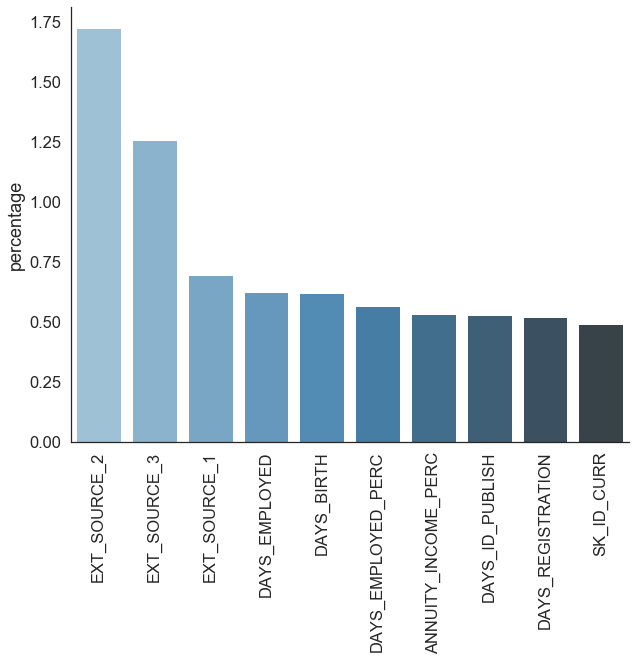

In [17]:
df_features = pd.DataFrame(d_features.items(), columns=['feature_name', 'percentage'])
df_features['percentage'] = df_features['percentage']*100
graph_selection_feature(df_features, 10)

In [18]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=100)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['feature_name','Score']  #naming the dataframe columns
d_features_kbest = featureScores.nlargest(100,'Score')  #print 10 best features


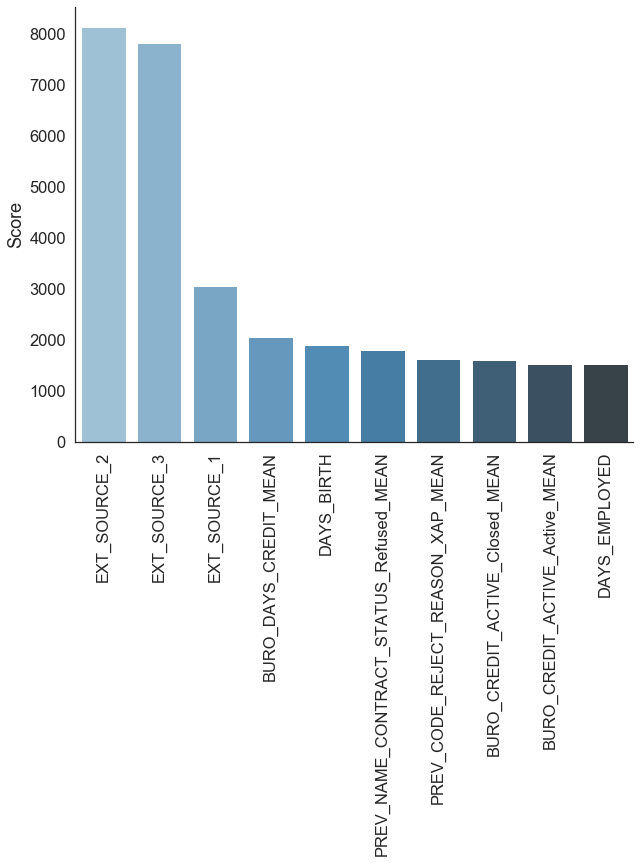

In [19]:
graph_selection_feature(d_features_kbest, 10)

In [20]:
features_rndf = list(d_features.keys())
features_kbest = list(d_features_kbest['feature_name'])
common_features = [f for f in features_rndf[:100] if f in features_kbest]
len(common_features)

36

### Analyse univarié

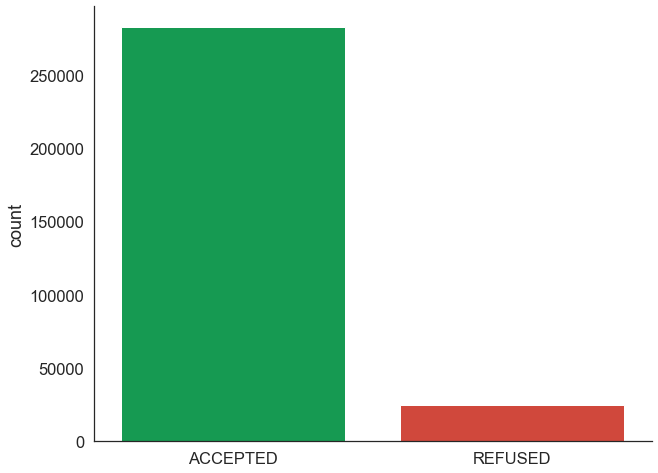

In [21]:
sns.set(font_scale = 1.5)
sns.set_style("white")
colors = ["#00B050", "#E93323"]
fig = plt.figure(figsize = (10,8))
ax = sns.countplot(df['TARGET'], palette =sns.color_palette(colors))
ax.set_xticklabels(['ACCEPTED','REFUSED'])
ax.set(xlabel=None)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [22]:
best_columns = common_features

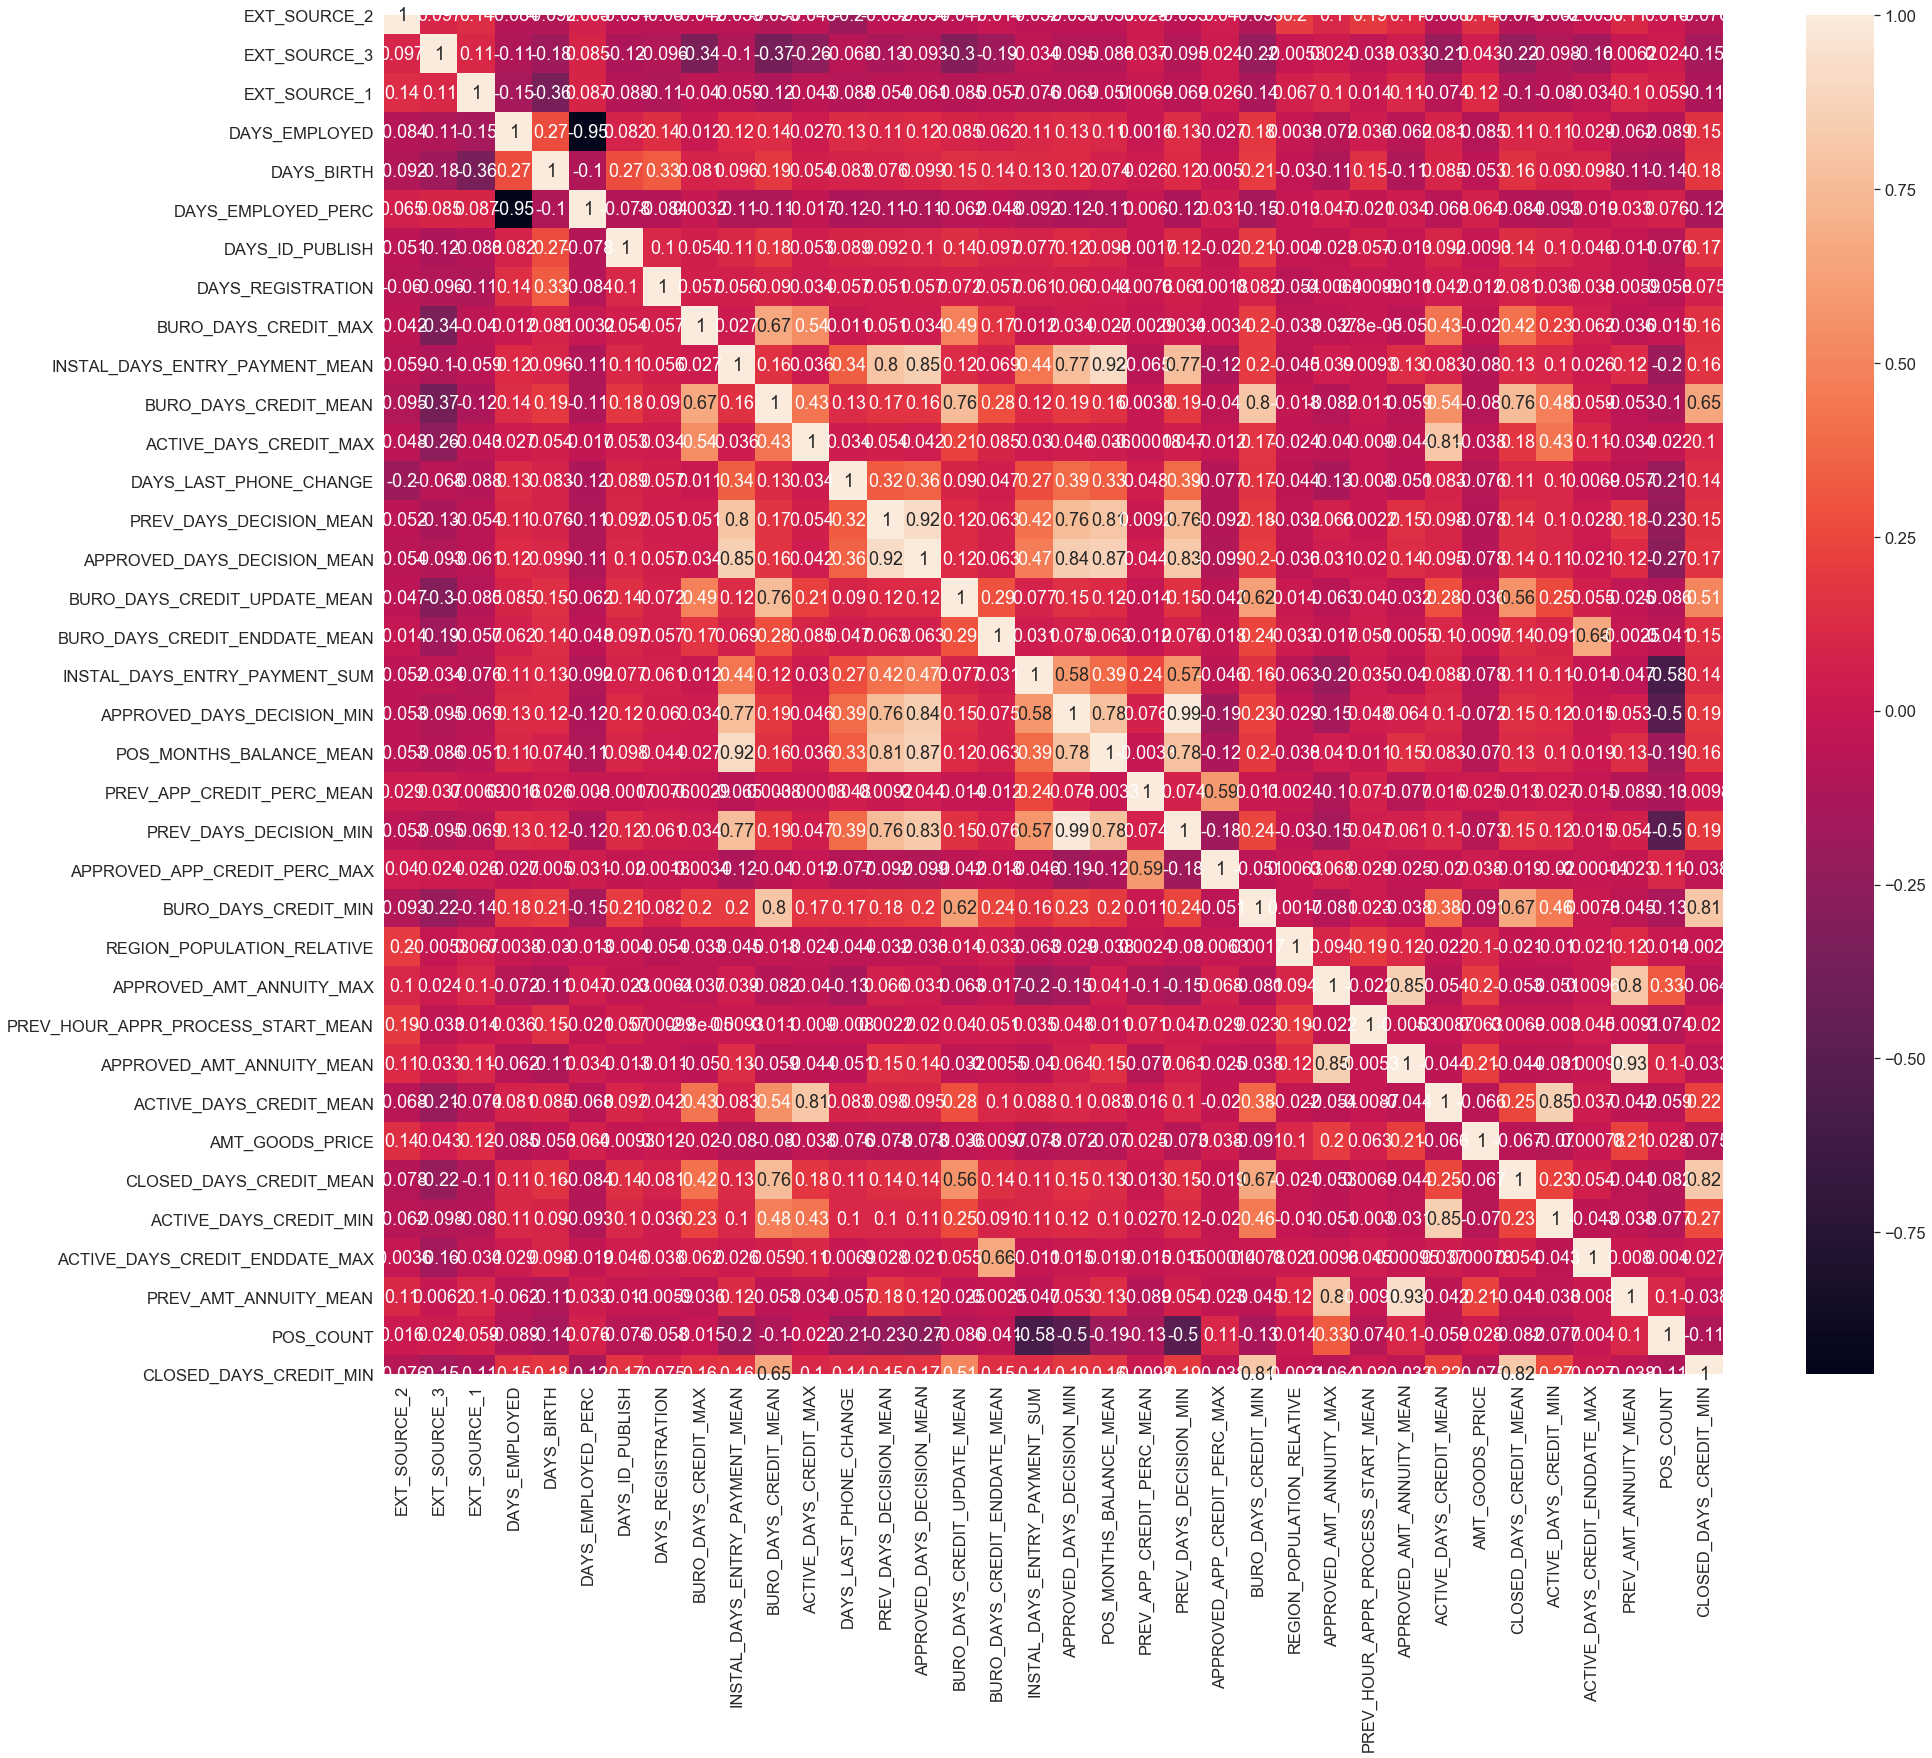

In [23]:
sns.set(font_scale = 1.5)
fig = plt.figure(figsize = (30,25))
ax = sns.heatmap(df_filled[best_columns].corr(), annot=True)

A l'aide de la matrice de corrélation, on cherche a supprimer les features qui sont redondantes:
- DAYS_EMPLOYED
- BURO_DAYS_CREDIT_UPDATE_MEAN 
- BURO_DAYS_CREDIT_MIN
- CLOSED_DAYS_CREDIT_MEAN
- PREV_DAYS_DECISION_MEAN
- APPROVED_DAYS_DECISION_MEAN
- PREV_DAYS_DECISION_MIN
- POS_MONTHS_BALANCE_MEAN
- APPROVED_DAYS_DECISION_MIN
- APPROVED_AMT_ANNUITY_MEAN
- PREV_AMT_ANNUITY_MEAN
- ACTIVE_DAYS_CREDIT_MEAN
- POS_COUNT

In [24]:
col_to_remove = ['DAYS_EMPLOYED', 'BURO_DAYS_CREDIT_UPDATE_MEAN','BURO_DAYS_CREDIT_MIN',
'CLOSED_DAYS_CREDIT_MEAN','PREV_DAYS_DECISION_MEAN','APPROVED_DAYS_DECISION_MEAN',
'PREV_DAYS_DECISION_MIN','POS_MONTHS_BALANCE_MEAN', 'APPROVED_DAYS_DECISION_MIN',
'APPROVED_AMT_ANNUITY_MEAN', 'PREV_AMT_ANNUITY_MEAN', 'ACTIVE_DAYS_CREDIT_MEAN', 'POS_MONTHS_BALANCE_SIZE']
best_columns = [col for col in best_columns if not col in col_to_remove]

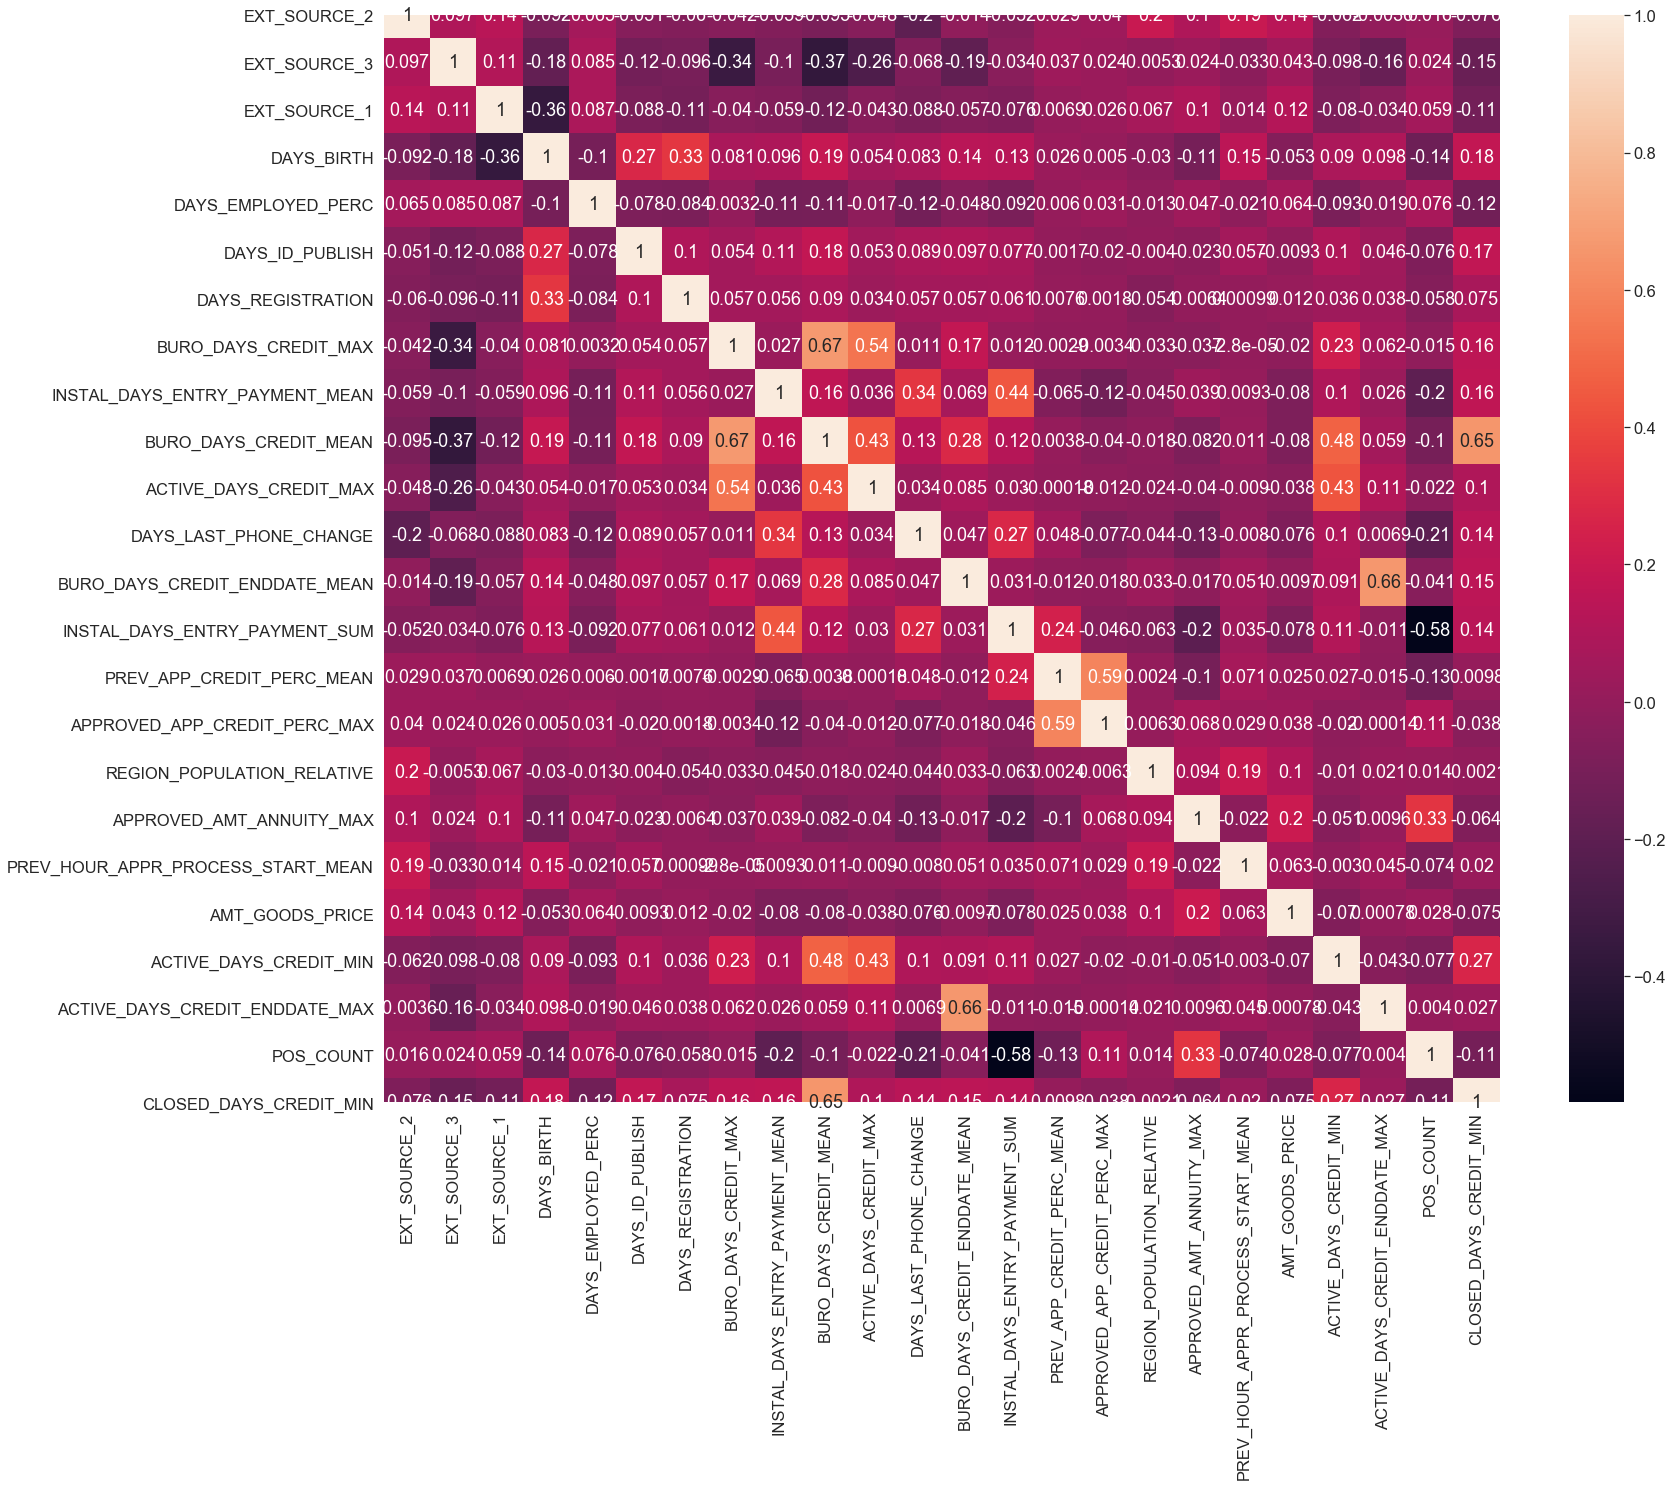

In [25]:
sns.set(font_scale = 1.5)
fig = plt.figure(figsize = (25,20))
ax = sns.heatmap(df_filled[best_columns].corr(), annot=True)


In [26]:
X_values = df_filled[best_columns]
y_values = df_filled['TARGET']

### Split le dataset en train et test

On sépare le jeu de donnée en un jeu d'entrainement et de test avec les donnée imballanced

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.3, random_state=1, stratify=y_values)

### Equilibrage du dataset
On cherche à équilibré de différentes manières le jeu de donnée: 
- class Weight
- SMOTE

### Class Weight

Pour utiliser le class weight, on passe par la régression logistique

from sklearn.utils import class_weight 
class_weight.compute_class_weight ('balanced', np.unique(y_train), y_train)

### SMOTE

In [28]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

#  Missions 2
Le points suivant vont êtres détaillés dans la suite de ce notebook:
- Modélisation de deux modeles linéaires 
    - Regression logistique
    - Regression Ridge
- Modélisation de deux modèles non linéaire
    - LightGBM
    - Random forest
- Mise en place un score personnalisé orienté bancaire

In [29]:
def model_evaluation_report(y, y_pred):
    row = {}
    row['accuracy'] = accuracy_score(y, y_pred)
    row['precision'] = precision_score(y, y_pred, average = 'binary')
    row['recall'] = recall_score(y, y_pred, average = 'binary')
    row['roc_auc'] = roc_auc_score(y, y_pred)
    row['f1_score'] = f1_score(y, y_pred, average = 'binary')
    tn, fp,fn,tp = confusion_matrix(y_test, y_pred).ravel()
    row['True Negative'] = tn
    row['True Positive'] = tp  
    row['False Negative'] = fn    
    row['False Positive'] = fp 
    return row

<b><font size= 5, color='green'>Regression logistique </font></b>

In [30]:
def logistic_regression(X_train, y_train, X_test, class_weight = None ):
    lr = LogisticRegression(solver='newton-cg', class_weight = class_weight)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return(y_pred)

#### Prediction using SMOTE results

In [31]:
y_pred = logistic_regression(X_train_SMOTE, y_train_SMOTE, X_test)
d_logistic_regression_smote = model_evaluation_report(y_test, y_pred) 

#### Prediction using CLASS WEIGHT results

In [32]:
y_pred = logistic_regression(X_train, y_train, X_test,class_weight = 'balanced')
d_logistic_regression_class_weight = model_evaluation_report(y_test, y_pred)

<b><font size= 5, color='green'>Regression Ridge </font></b>

In [33]:
from sklearn.linear_model import RidgeClassifier
def ridge_regression(X_train, y_train, X_test, class_weight = None ):
    lr = RidgeClassifier(class_weight = class_weight)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return(y_pred)

#### Prediction using SMOTE results

In [34]:
y_pred = ridge_regression(X_train_SMOTE, y_train_SMOTE, X_test)
d_ridge_regression_smote = model_evaluation_report(y_test, y_pred) 

#### Prediction using CLASS WEIGHT results

In [35]:
y_pred = ridge_regression(X_train, y_train, X_test,class_weight = 'balanced')
d_ridge_regression_class_weight = model_evaluation_report(y_test, y_pred) 

<b><font size= 5, color='green'>LIGHT GBM classifier </font></b>

In [36]:
def LGBM_classifier(X_train, y_train, X_test, class_weight = None ): 
    model = LGBMClassifier(class_weight = class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return(y_pred)

#### Prediction using SMOTE results

In [37]:
y_pred = LGBM_classifier(X_train_SMOTE, y_train_SMOTE, X_test)
d_LGBM_classifier_smote = model_evaluation_report(y_test, y_pred) 

#### Prediction using CLASS WEIGHT results

In [38]:
y_pred = LGBM_classifier(X_train, y_train, X_test,class_weight = 'balanced')
d_LGBM_classifier_class_weight = model_evaluation_report(y_test, y_pred) 

<b><font size= 5, color='green'>Random forest classifier </font></b>

In [39]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(X_train, y_train, X_test, class_weight = None ):
    model = RandomForestClassifier(class_weight = class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return(y_pred)

#### Prediction using SMOTE results

In [40]:
y_pred = random_forest_classifier(X_train_SMOTE, y_train_SMOTE, X_test)
d_random_forest_classifier_smote = model_evaluation_report(y_test, y_pred) 


#### Prediction using CLASS WEIGHT results

In [41]:
y_pred = random_forest_classifier(X_train, y_train, X_test, class_weight = 'balanced')
d_random_forest_classifier_class_weight = model_evaluation_report(y_test, y_pred) 

## Présentation des résultats

In [62]:
def graph_results(df):
    sns.set(font_scale = 1.5)
    sns.set_style("white")

    ax = df.plot.bar(rot=0, figsize = (10,8), title="Number of predictions per correlation matrix values for each model")
    ax.set(xlabel=None)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [43]:
df_evaluation_smote = pd.DataFrame([d_logistic_regression_smote, d_ridge_regression_smote,
                                    d_LGBM_classifier_smote, d_random_forest_classifier_smote], 
                                  index=['logistic_regression', 'ridge_regression', 'LGBM_classifier'
                                        , 'random_forest_classifier'])
df_evaluation_smote

,accuracy,precision,recall,roc_auc,f1_score,True Negative,True Positive,False Negative,False Positive
logistic_regression,0.688209,0.153579,0.634398,0.663666,0.247292,58765,4725,2723,26041
ridge_regression,0.683006,0.154098,0.651853,0.668797,0.249268,58155,4855,2593,26651
LGBM_classifier,0.901609,0.225665,0.089957,0.531424,0.128636,82507,670,6778,2299
random_forest_classifier,0.863117,0.185298,0.204753,0.562845,0.194540,78101,1525,5923,6705


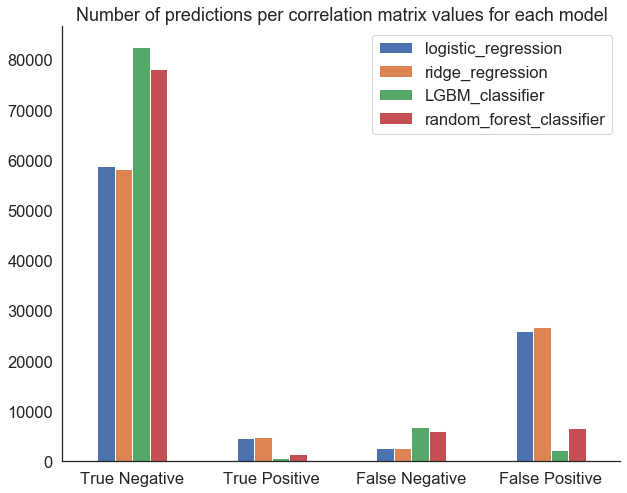

In [63]:
df_plot = df_evaluation_smote.loc[:,['True Negative','True Positive', 'False Negative', 'False Positive']].transpose()
graph_results(df_plot )


In [45]:
df_evaluation_class_weight = pd.DataFrame([d_logistic_regression_class_weight, d_ridge_regression_class_weight,
                                    d_LGBM_classifier_class_weight, d_random_forest_classifier_class_weight], 
                                  index=['logistic_regression', 'ridge_regression', 'LGBM_classifier'
                                        , 'random_forest_classifier'])
df_evaluation_class_weight

,accuracy,precision,recall,roc_auc,f1_score,True Negative,True Positive,False Negative,False Positive
logistic_regression,0.683363,0.153290,0.645945,0.666297,0.247779,58232,4811,2637,26574
ridge_regression,0.680632,0.153449,0.654404,0.668670,0.248604,57917,4874,2574,26889
LGBM_classifier,0.705032,0.166532,0.662594,0.685676,0.266167,60107,4935,2513,24699
random_forest_classifier,0.919386,0.579710,0.005371,0.502514,0.010643,84777,40,7408,29


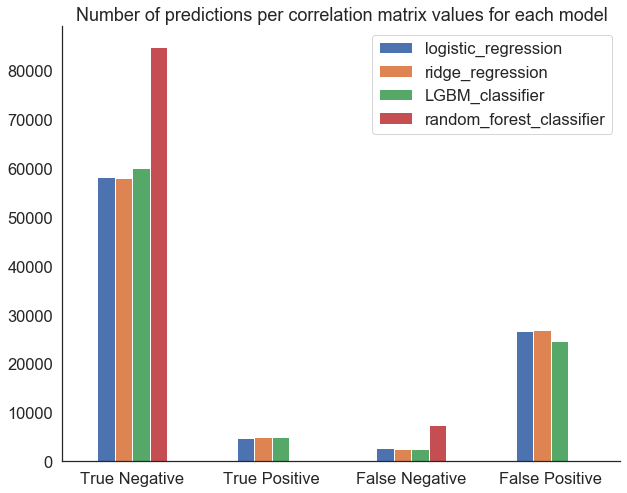

In [64]:
df_plot = df_evaluation_class_weight.loc[:,['True Negative','True Positive', 'False Negative', 'False Positive']].transpose()
graph_results(df_plot )

Le choix du meilleur modèle sur lequel les hyperparamètres vont être optimisés dans le but de réduire principalement le nombre de faux négatifs puis le nombre de faux positifs.
On choisi donc le modèle pour lequel on obtient les meilleurs résultats parmis ceux qui ont étés tester:
Le modèle a optimisé est donc :

**LGBM_classifier avec un équilibrage du jeu de données à l'aide de class weight**

#  Missions 4
Le points suivant vont êtres détaillés dans la suite de ce notebook:
- Mettre en place la fonction orientée bancaire
- Optimiser le meilleur suivant cette. fonction
- Faire l'interprétabilité globale et individuelle du modèle avec shap
- Déployer le meilleur avec flask sous forme d'api
- Versioning du code

### OPTIMISATION DES HYPERPARAMETRES

Afin d'optimiser en réduisant le nombre de faux négatifs et de faux positif, on creer une fonction qui affect un poid aux différentes valeurs de la mattrice de confusion et on cherche a minimiser cette fonction.
Les poids que l'on souhaite affecter sont les suivants:
- Vrai positifs : 1
- Vrai négatifs : 1
- Faux positifs : 2
- Faux négatifs : 15

In [47]:
def func_scoring(y_test, y_pred):
    tn,fp,fn,tp = confusion_matrix(y_test, y_pred).ravel()
    score = tp + tn + 2*fp + 15*fn
    return(-score)
        

In [48]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': list(range(3,4)),
    'num_leaves' : list(range(20,200, 20)),
    'learning_rate': [0.01, 0.11, 0.21, 0.31],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = LGBMClassifier(class_weight = 'balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring=make_scorer(func_scoring), verbose=10, cv = 3)

In [49]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3; 1/144] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20
[CV 1/3; 1/144] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20;, score=-122180.000 total time=   1.2s
[CV 2/3; 1/144] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20
[CV 2/3; 1/144] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20;, score=-122446.000 total time=   1.2s
[CV 3/3; 1/144] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20
[CV 3/3; 1/144] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=20;, score=-121521.000 total time=   1.2s
[CV 1/3; 2/144] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=40
[CV 1/3; 2/144] END learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=40;, score=-122180.000 total time=   1.2s
[CV 2/3; 2/144] START learning_rate=0.01, max_depth=3, n_estimators=100, num_leaves=40
[CV 2/

[CV 3/3; 13/144] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=80;, score=-120806.000 total time=   1.9s
[CV 1/3; 14/144] START learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=100
[CV 1/3; 14/144] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=100;, score=-120942.000 total time=   1.8s
[CV 2/3; 14/144] START learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=100
[CV 2/3; 14/144] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=100;, score=-120643.000 total time=   1.8s
[CV 3/3; 14/144] START learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=100
[CV 3/3; 14/144] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=100;, score=-120806.000 total time=   4.4s
[CV 1/3; 15/144] START learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=120
[CV 1/3; 15/144] END learning_rate=0.01, max_depth=3, n_estimators=200, num_leaves=120;, score=-120942.000 total time=   3.7s
[CV 2/3; 15/144

[CV 3/3; 26/144] END learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=160;, score=-120503.000 total time=   2.8s
[CV 1/3; 27/144] START learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=180
[CV 1/3; 27/144] END learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=180;, score=-120295.000 total time=   2.9s
[CV 2/3; 27/144] START learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=180
[CV 2/3; 27/144] END learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=180;, score=-119626.000 total time=   2.4s
[CV 3/3; 27/144] START learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=180
[CV 3/3; 27/144] END learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=180;, score=-120503.000 total time=   2.8s
[CV 1/3; 28/144] START learning_rate=0.01, max_depth=3, n_estimators=1000, num_leaves=20
[CV 1/3; 28/144] END learning_rate=0.01, max_depth=3, n_estimators=1000, num_leaves=20;, score=-118640.000 total time=   7.0s
[CV 2/3; 28/14

[CV 3/3; 39/144] END learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=60;, score=-119096.000 total time=   1.1s
[CV 1/3; 40/144] START learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=80
[CV 1/3; 40/144] END learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=80;, score=-118805.000 total time=   1.1s
[CV 2/3; 40/144] START learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=80
[CV 2/3; 40/144] END learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=80;, score=-117315.000 total time=   1.1s
[CV 3/3; 40/144] START learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=80
[CV 3/3; 40/144] END learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=80;, score=-119096.000 total time=   1.3s
[CV 1/3; 41/144] START learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=100
[CV 1/3; 41/144] END learning_rate=0.11, max_depth=3, n_estimators=100, num_leaves=100;, score=-118805.000 total time=   1.4s
[CV 2/3; 41/144] STAR

[CV 3/3; 52/144] END learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=140;, score=-118713.000 total time=   1.9s
[CV 1/3; 53/144] START learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=160
[CV 1/3; 53/144] END learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=160;, score=-118199.000 total time=   1.7s
[CV 2/3; 53/144] START learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=160
[CV 2/3; 53/144] END learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=160;, score=-117180.000 total time=   1.7s
[CV 3/3; 53/144] START learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=160
[CV 3/3; 53/144] END learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=160;, score=-118713.000 total time=   1.7s
[CV 1/3; 54/144] START learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=180
[CV 1/3; 54/144] END learning_rate=0.11, max_depth=3, n_estimators=200, num_leaves=180;, score=-118199.000 total time=   1.7s
[CV 2/3; 54/14

[CV 3/3; 65/144] END learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=40;, score=-119607.000 total time=   6.8s
[CV 1/3; 66/144] START learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=60
[CV 1/3; 66/144] END learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=60;, score=-119080.000 total time=   8.0s
[CV 2/3; 66/144] START learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=60
[CV 2/3; 66/144] END learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=60;, score=-118293.000 total time=   7.6s
[CV 3/3; 66/144] START learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=60
[CV 3/3; 66/144] END learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=60;, score=-119607.000 total time=   8.8s
[CV 1/3; 67/144] START learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=80
[CV 1/3; 67/144] END learning_rate=0.11, max_depth=3, n_estimators=1000, num_leaves=80;, score=-119080.000 total time=   7.6s
[CV 2/3; 67/14

[CV 3/3; 78/144] END learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=120;, score=-118905.000 total time=   1.1s
[CV 1/3; 79/144] START learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=140
[CV 1/3; 79/144] END learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=140;, score=-118733.000 total time=   1.1s
[CV 2/3; 79/144] START learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=140
[CV 2/3; 79/144] END learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=140;, score=-117203.000 total time=   1.3s
[CV 3/3; 79/144] START learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=140
[CV 3/3; 79/144] END learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=140;, score=-118905.000 total time=   1.3s
[CV 1/3; 80/144] START learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=160
[CV 1/3; 80/144] END learning_rate=0.21, max_depth=3, n_estimators=100, num_leaves=160;, score=-118733.000 total time=   1.2s
[CV 2/3; 80/14

[CV 3/3; 91/144] END learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=20;, score=-119025.000 total time=   2.4s
[CV 1/3; 92/144] START learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=40
[CV 1/3; 92/144] END learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=40;, score=-118748.000 total time=   2.5s
[CV 2/3; 92/144] START learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=40
[CV 2/3; 92/144] END learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=40;, score=-117514.000 total time=   2.4s
[CV 3/3; 92/144] START learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=40
[CV 3/3; 92/144] END learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=40;, score=-119025.000 total time=   2.1s
[CV 1/3; 93/144] START learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=60
[CV 1/3; 93/144] END learning_rate=0.21, max_depth=3, n_estimators=300, num_leaves=60;, score=-118748.000 total time=   2.5s
[CV 2/3; 93/144] START 

[CV 3/3; 104/144] END learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=100;, score=-121138.000 total time=   7.0s
[CV 1/3; 105/144] START learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=120
[CV 1/3; 105/144] END learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=120;, score=-121039.000 total time=   6.6s
[CV 2/3; 105/144] START learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=120
[CV 2/3; 105/144] END learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=120;, score=-120110.000 total time=   6.5s
[CV 3/3; 105/144] START learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=120
[CV 3/3; 105/144] END learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=120;, score=-121138.000 total time=   6.3s
[CV 1/3; 106/144] START learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=140
[CV 1/3; 106/144] END learning_rate=0.21, max_depth=3, n_estimators=1000, num_leaves=140;, score=-121039.000 total time=   6

[CV 2/3; 117/144] END learning_rate=0.31, max_depth=3, n_estimators=100, num_leaves=180;, score=-117663.000 total time=   1.1s
[CV 3/3; 117/144] START learning_rate=0.31, max_depth=3, n_estimators=100, num_leaves=180
[CV 3/3; 117/144] END learning_rate=0.31, max_depth=3, n_estimators=100, num_leaves=180;, score=-118588.000 total time=   1.1s
[CV 1/3; 118/144] START learning_rate=0.31, max_depth=3, n_estimators=200, num_leaves=20
[CV 1/3; 118/144] END learning_rate=0.31, max_depth=3, n_estimators=200, num_leaves=20;, score=-118593.000 total time=   1.8s
[CV 2/3; 118/144] START learning_rate=0.31, max_depth=3, n_estimators=200, num_leaves=20
[CV 2/3; 118/144] END learning_rate=0.31, max_depth=3, n_estimators=200, num_leaves=20;, score=-117992.000 total time=   2.1s
[CV 3/3; 118/144] START learning_rate=0.31, max_depth=3, n_estimators=200, num_leaves=20
[CV 3/3; 118/144] END learning_rate=0.31, max_depth=3, n_estimators=200, num_leaves=20;, score=-118959.000 total time=   1.9s
[CV 1/3; 11

[CV 1/3; 130/144] END learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=80;, score=-119352.000 total time=   2.3s
[CV 2/3; 130/144] START learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=80
[CV 2/3; 130/144] END learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=80;, score=-118355.000 total time=   2.4s
[CV 3/3; 130/144] START learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=80
[CV 3/3; 130/144] END learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=80;, score=-119351.000 total time=   2.5s
[CV 1/3; 131/144] START learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=100
[CV 1/3; 131/144] END learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=100;, score=-119352.000 total time=   2.3s
[CV 2/3; 131/144] START learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=100
[CV 2/3; 131/144] END learning_rate=0.31, max_depth=3, n_estimators=300, num_leaves=100;, score=-118355.000 total time=   2.3s
[CV 3/3; 1

[CV 3/3; 142/144] END learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=140;, score=-122941.000 total time=   7.4s
[CV 1/3; 143/144] START learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=160
[CV 1/3; 143/144] END learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=160;, score=-122556.000 total time=   7.0s
[CV 2/3; 143/144] START learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=160
[CV 2/3; 143/144] END learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=160;, score=-121745.000 total time=   6.8s
[CV 3/3; 143/144] START learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=160
[CV 3/3; 143/144] END learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=160;, score=-122941.000 total time=   6.7s
[CV 1/3; 144/144] START learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=180
[CV 1/3; 144/144] END learning_rate=0.31, max_depth=3, n_estimators=1000, num_leaves=180;, score=-122556.000 total time=   7

GridSearchCV(cv=3, estimator=LGBMClassifier(class_weight='balanced'),
             param_grid={'learning_rate': [0.01, 0.11, 0.21, 0.31],
                         'max_depth': [3],
                         'n_estimators': [100, 200, 300, 1000],
                         'num_leaves': [20, 40, 60, 80, 100, 120, 140, 160,
                                        180]},
             scoring=make_scorer(func_scoring), verbose=10)

In [50]:
grid_search.best_params_

{'learning_rate': 0.11, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 20}

In [51]:
model_lgbm = LGBMClassifier(class_weight = 'balanced',learning_rate= 0.11,
                    max_depth = 3, n_estimators = 300, num_leaves = 20)
model_lgbm.fit(X_train, y_train)
y_pred = model_lgbm.predict(X_test)
model_evaluation_report(y_test, y_pred) 

{'accuracy': 0.7001864417803022,
 'precision': 0.16521451051846944,
 'recall': 0.6695757250268528,
 'roc_auc': 0.6862252608107167,
 'f1_score': 0.2650333483910398,
 'True Negative': 59608,
 'True Positive': 4987,
 'False Negative': 2461,
 'False Positive': 25198}

In [52]:
y_pred = model_lgbm.predict(X_test)
model_evaluation_report(y_test, y_pred) 

{'accuracy': 0.7001864417803022,
 'precision': 0.16521451051846944,
 'recall': 0.6695757250268528,
 'roc_auc': 0.6862252608107167,
 'f1_score': 0.2650333483910398,
 'True Negative': 59608,
 'True Positive': 4987,
 'False Negative': 2461,
 'False Positive': 25198}

In [53]:
df_evaluation_optimized = pd.DataFrame([model_evaluation_report(y_test, y_pred)], 
                                  index=['LGBM_classifier'])

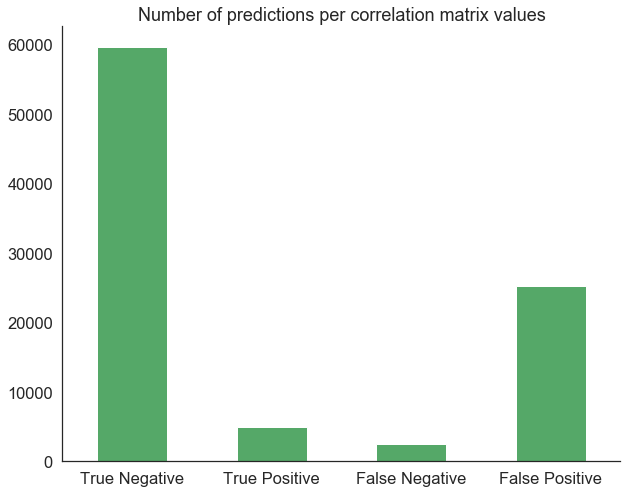

In [54]:
df_plot = df_evaluation_optimized.loc[:,['True Negative','True Positive', 'False Negative', 'False Positive']].transpose()
graph_results(df_plot)

### INTERPRETATION DES VARIABLES GLOBALES

In [55]:
import shap
shap.initjs()

In [56]:
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(X_values)
expected_values = explainer.expected_value

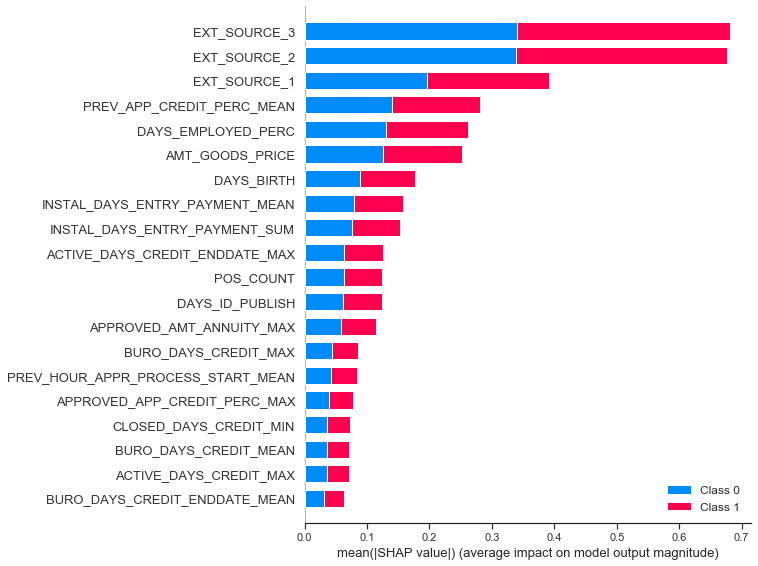

In [57]:
sns.set_style("white")
shap.summary_plot(shap_values, X_values)

### INTERPRETATION DES VARIABLES LOCALES

In [58]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], best_columns)

In [59]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], best_columns)

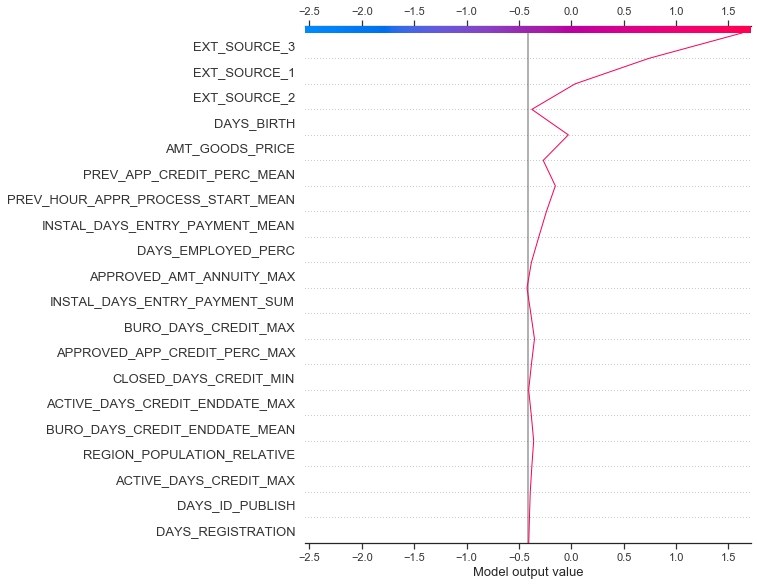

In [60]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], best_columns)

### EXPORT DES DONNES

In [61]:
import pickle
pickle.dump(model_lgbm, open('Scoring_model.pkl', 'wb'))

SyntaxError: invalid syntax (<ipython-input-61-f62314fbc14f>, line 1)

In [ ]:
df_export = df_filled[best_columns].sample(n = 15000)
df_export.to_csv('P7_client_selected_data.csv', index=False)

In [ ]:
shap_values = explainer.shap_values(df_export)
expected_values = explainer.expected_value

In [ ]:
import pickle
pickle.dump([shap_values,expected_values] , open('explainer_results.pkl', 'wb'))